In [13]:
# initializations and imports
import matplotlib as plt
import numpy as np
from qiskit import QuantumCircuit, transpile, execute, QuantumRegister, ClassicalRegister
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram

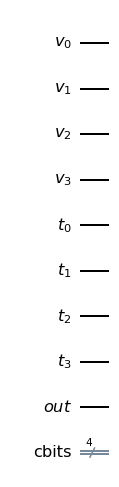

In [14]:
# 4 qubits for the sudoku bits
var_qubits = QuantumRegister(4, name = "v")

# 4 qubits for the tests
test_qubits = QuantumRegister(4, name = "t")

# 1 output qubit to store the output of the tests
output_qubit = QuantumRegister(1, name = 'out')

# 4 classical qubits to store the results from the measurements of the variable qubits
classical_qubits = ClassicalRegister(4, name = "cbits")

# create the quantum circuit
circuit = QuantumCircuit(var_qubits, test_qubits, output_qubit, classical_qubits)

# draw the circuit
circuit.draw('mpl')

In [15]:
# xor operation to check if inputs are the same or not
def XOR(circuit, input1, input2, output) :
    circuit.cx(input1, output)
    circuit.cx(input2, output)

def sudoku_oracle(circuit, var_qubits, test_qubits, output_qubit) :
    clause_list = [[0,1],
                [0,2],
                [1,3],
                [2,3]]

    i = 0

    for clause in clause_list:
        XOR(circuit, clause[0], clause[1], test_qubits[i])
        i += 1

    circuit.barrier()

    # if all control qubits are 1, sudoku is solved, so it whould flip the output qubit
    circuit.mct(test_qubits, output_qubit)

    circuit.barrier()

    # now reset the test qubits, to use them in the grover operation
    i = 0

    for clause in clause_list:
        XOR(circuit, clause[0], clause[1], test_qubits[i])
        i += 1

def diffuser(nqubits) :
    qc = QuantumCircuit(nqubits)

    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)

    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    
    return U_s

    circuit.barrier()

In [16]:
# apply hadamard gates
circuit.h(var_qubits)

# Initialize 'out0' in state |->
circuit.initialize([1, -1]/np.sqrt(2), output_qubit)

circuit.barrier()

# execute sudoku oracle 1st time
sudoku_oracle(circuit, var_qubits, test_qubits, output_qubit)

circuit.barrier()

circuit.append(diffuser(4), [0, 1, 2, 3])

# execute sudoku oracle 2st time
sudoku_oracle(circuit, var_qubits, test_qubits, output_qubit)

circuit.barrier()

circuit.append(diffuser(4), [0, 1, 2, 3])

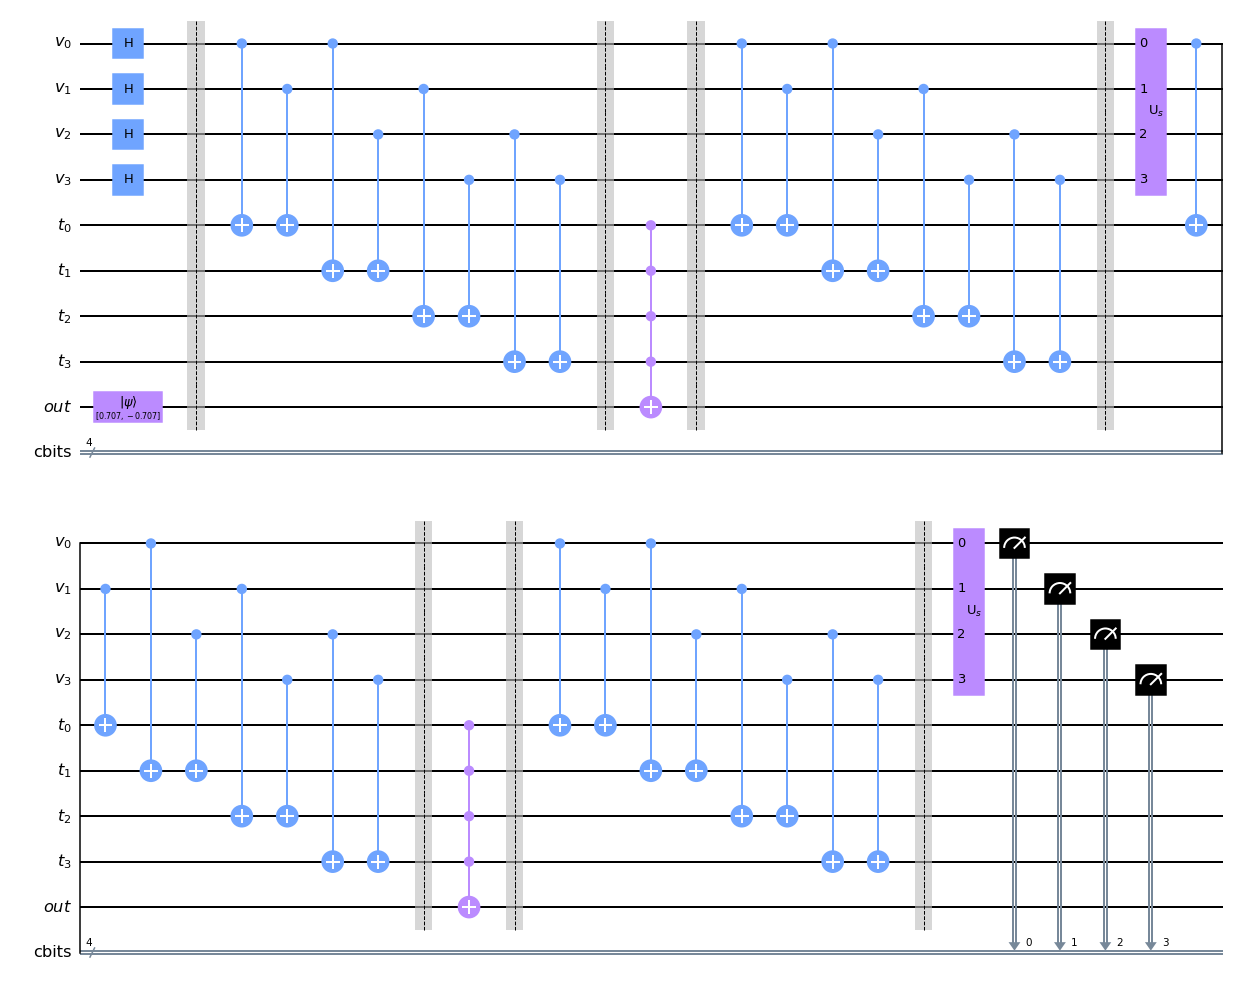

In [17]:
# measure 4 var qubits
circuit.measure(var_qubits, classical_qubits)

circuit.draw('mpl')

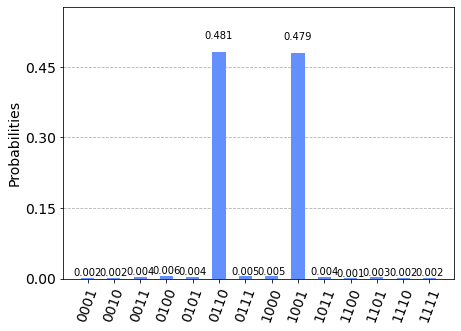

In [18]:
# simulate results
from qiskit import Aer
simulator = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend = simulator, shots = 1000).result()

counts = result.get_counts()

plot_histogram(counts)